In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [2]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1 / 12
num_paths = 50000

# Functions

In [4]:
def calculate_black_scholes_d1_d2(S: float, K: float, r: float, T: float, sigma: float) -> tuple[float, float]:
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

In [5]:
def black_scholes_vanilla_call(S: float, K: float, r: float, T: float, sigma: float) -> float:
    d1, d2 = calculate_black_scholes_d1_d2(S, K, r, T, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [6]:
def calculate_stock_prices(S, r, sigma, t, W):
    return S * np.exp((r * t - 0.5 * sigma**2 * t) + sigma * W)

In [7]:
def calculate_phi(S_t, K, r, sigma, T, t):
    T_minus_t = T - t
    T_minus_t[T_minus_t == 0] = 1e-10  # Avoid division by zero
    d1 = (np.log(S_t / K) + (r + 0.5 * sigma**2) * T_minus_t) / (sigma * np.sqrt(T_minus_t))
    return norm.cdf(d1)

In [8]:
def calculate_psi_Bt(S_t, K, r, sigma, T, t):
    T_minus_t = T - t
    T_minus_t[T_minus_t == 0] = 1e-10  # Avoid division by zero
    d2 = (np.log(S_t / K) + (r - 0.5 * sigma**2) * (T_minus_t)) / (sigma * np.sqrt(T_minus_t))
    return -K * np.exp(-r * T_minus_t) * norm.cdf(d2)

In [9]:
def simulate_brownian_paths(paths, T, steps):
    delta_t = T / steps
    timestamps = np.linspace(0, T, steps + 1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return timestamps, np.cumsum(np.sqrt(delta_t) * X, axis=1)

In [10]:
def calculate_final_hedging_errors(S0, K, r, sigma, T, n_steps, num_paths):
    timestamps, brownian_paths = simulate_brownian_paths(num_paths, T, n_steps)
    simulated_stock_prices = calculate_stock_prices(S0, r, sigma, timestamps, brownian_paths)
    current_timestamps = timestamps[:-1].reshape(1, -1)

    deltas = calculate_phi(simulated_stock_prices[:, :-1], K, r, sigma, T, current_timestamps)
    bond_positions = calculate_psi_Bt(simulated_stock_prices[:, :-1], K, r, sigma, T, current_timestamps)

    stock_price_changes = np.diff(simulated_stock_prices, axis=1)
    time_step_size = T / n_steps

    stock_pnl = deltas * stock_price_changes
    bond_pnl = bond_positions * r * time_step_size

    total_hedging_pnl = stock_pnl + bond_pnl
    cumulative_pnl = np.sum(total_hedging_pnl, axis=1)

    option_payoff = np.maximum(simulated_stock_prices[:, -1] - K, 0)
    initial_option_price = black_scholes_vanilla_call(S0, K, r, sigma, T)

    final_pnl = (cumulative_pnl + initial_option_price) - option_payoff
    return final_pnl

In [11]:
def plot_pnl_distribution(hedging_errors, n_steps, num_paths):
    plt.hist(hedging_errors, bins=50, range=(-1.5, 1.5), facecolor='red', alpha=0.7, weights=(np.ones_like(hedging_errors)/num_paths)*100)
    plt.title(f'Hedging Error Histogram (N = {n_steps})')
    plt.xlabel('Final P&L (Hedging Error)')
    plt.ylabel('Frequency (out of 100%)')
    plt.grid(True)
    plt.show()

In [12]:
def generate_hedging_error_stats(hedging_errors):
    stats = {
        "Mean": hedging_errors.mean(),
        "Standard Deviation": hedging_errors.std(),
        "Minimum": hedging_errors.min(),
        "Maximum": hedging_errors.max(),
        "25th Percentile": hedging_errors.quantile(0.25),
        "Median (50th Percentile)": hedging_errors.median(),
        "75th Percentile": hedging_errors.quantile(0.75),
    }
    return pd.DataFrame(stats, index=["Hedging Error Statistics"])

# N=21

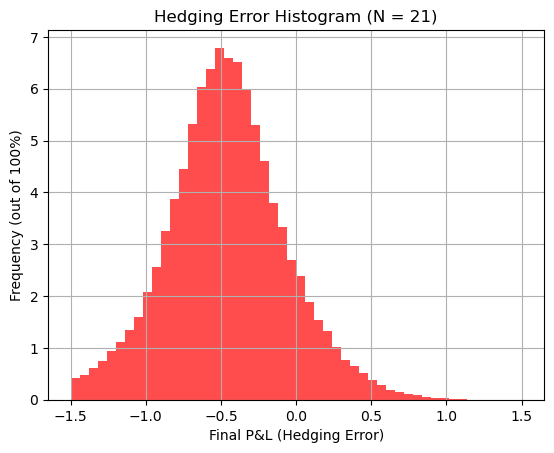

,Mean,Standard Deviation,Minimum,Maximum,25th Percentile,Median (50th Percentile),75th Percentile
Hedging Error Statistics,-0.485012,0.428471,-4.644039,1.268523,-0.723948,-0.478255,-0.229365


In [14]:
steps = 21
timestamps, brownian_paths = simulate_brownian_paths(num_paths, T, steps)
hedging_errors = calculate_final_hedging_errors(S0, K, r, sigma, T, steps, num_paths)
plot_pnl_distribution(hedging_errors, steps, num_paths)
generate_hedging_error_stats(pd.Series(hedging_errors))

# N=84

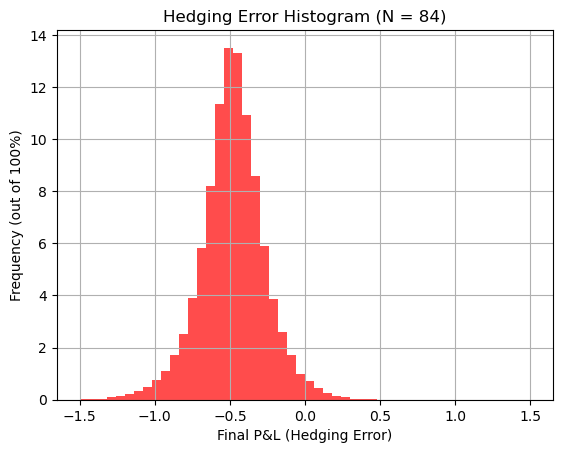

,Mean,Standard Deviation,Minimum,Maximum,25th Percentile,Median (50th Percentile),75th Percentile
Hedging Error Statistics,-0.483187,0.216302,-1.92605,0.552002,-0.602877,-0.481412,-0.356985


In [16]:
steps = 84
timestamps, brownian_paths = simulate_brownian_paths(num_paths, T, steps)
hedging_errors = calculate_final_hedging_errors(S0, K, r, sigma, T, steps, num_paths)
plot_pnl_distribution(hedging_errors, steps, num_paths)
generate_hedging_error_stats(pd.Series(hedging_errors))

# Additional Analysis and Insights

## Approximate Interpretation for 𝝈𝑭𝒊𝒏𝒂𝒍 𝑷&𝑳 by Goldman Sachs Equity Derivatives Research

https://emanuelderman.com/when-you-cannot-hedge-continuously-the-corrections-of-black-scholes/

In [19]:
def kappa(S0, d1, T):
    return S0*np.sqrt(T)*(np.exp(-d1**2/2)/np.sqrt(2*np.pi))

In [20]:
def approxSD(S0, K, r, sigma, T, N):
    d1, _ = calculate_black_scholes_d1_d2(S0, K, r, T, sigma)
    return np.sqrt(np.pi/4)*kappa(S0,
                                  d1,
                                  T)*(sigma/np.sqrt(N))

In [21]:
N21_approxSD = approxSD(S0, K, r, sigma, T, 21)
N84_approxSD = approxSD(S0, K, r, sigma, T, 84)
print(f"N = 21, ApproxSD = {N21_approxSD:.6f}")
print(f"N = 84, ApproxSD = {N84_approxSD:.6f}")

N = 21, ApproxSD = 0.443168
N = 84, ApproxSD = 0.221584


## Standard deviation of hedging errors for different hedge frequencies

In [23]:
def calculate_hedging_std_vs_frequency(S0, K, r, sigma, T, paths, hedge_frequencies):
    std_devs = []
    for n_steps in hedge_frequencies:
        final_pl = calculate_final_hedging_errors(S0, K, r, sigma, T, n_steps, num_paths)
        # Compute standard deviation of the errors
        std_devs.append(np.std(final_pl))
    return std_devs

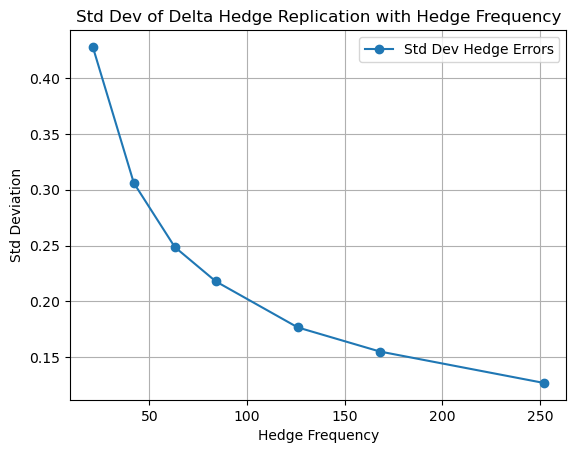

In [24]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1/12
num_paths = 50000  # Number of simulated paths
hedge_frequencies = [21, 42, 63, 84, 126, 168, 252]  # Different rebalancing frequencies

std_devs = calculate_hedging_std_vs_frequency(S0, K, r, sigma, T, num_paths, hedge_frequencies)

plt.plot(hedge_frequencies, std_devs, label="Std Dev Hedge Errors", marker='o')
plt.title("Std Dev of Delta Hedge Replication with Hedge Frequency")
plt.xlabel("Hedge Frequency")
plt.ylabel("Std Deviation")
plt.legend()
plt.grid()
plt.show()